In [18]:
import tensorflow as tf

In [1]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
%matplotlib inline

## Load Data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [3]:
print("Size of:")
print("Training Set: \t" + str(len(data.train.labels)))
print("Test Set: \t" + str(len(data.test.labels)))
print("Validation Set: \t" + str(len(data.validation.labels)))

Size of:
Training Set: 	55000
Test Set: 	10000
Validation Set: 	5000


In [5]:
data.test.labels[0:5,:]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

In [7]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])

In [8]:
data.test.cls[0:5]

array([7, 2, 1, 0, 4])

## Data dimensions

In [9]:
img_size = 28
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
num_classes = 10

In [13]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    fig,axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap="binary")
        
        if cls_pred is None:
            xlabel = "True: " + str(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        ax.set_xlabel(xlabel)
        
        ##Remove ticks from plot
        ax.set_xticks([])
        ax.set_yticks([])

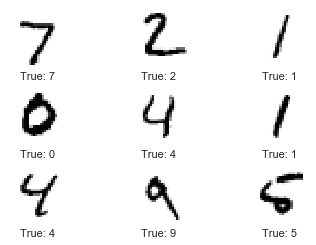

In [16]:
images = data.test.images[0:9]
cls_true = data.test.cls[0:9]
plot_images(images=images, cls_true=cls_true)

## Tensorflow

In [19]:
x = tf.placeholder(tf.float32, [None, img_size_flat])

In [21]:
y_true = tf.placeholder(tf.float32, [None, num_classes])

In [24]:
y_true_cls = tf.placeholder(tf.int64, [None])

In [26]:
weights = tf.Variable(tf.zeros([img_size_flat,num_classes]))

In [27]:
biases = tf.Variable(tf.zeros([num_classes]))

### Model

In [28]:
logits = tf.matmul(x, weights) + biases

In [29]:
y_pred = tf.nn.softmax(logits)

In [30]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

### Cost Function

In [31]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,\
                                                       labels=y_true)

In [32]:
cost = tf.reduce_mean(cross_entropy)

### Optimization method

In [33]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

### Performance Measures

In [35]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [36]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Run

### Create TensorFlow session

In [37]:
session = tf.Session()

### Initialize Variables

In [49]:
session.run(tf.global_variables_initializer())

### Helper-function to perform optimization iterations

In [40]:
batch_size = 100

In [41]:
def optimize(num_iterations):
    for i in range(num_iterations):
        x_batch , y_true_batch = data.train.next_batch(batch_size)
        feed_dict_train = {x:x_batch,
                          y_true:y_true_batch}
        session.run(optimizer, feed_dict=feed_dict_train)

### Helper-function to show performance

In [42]:
feed_dict_test = {x:data.test.images,
                 y_true: data.test.labels,
                 y_true_cls: data.test.cls}

In [43]:
def print_accuracy():
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [45]:
def print_confusion_matrix():
    cls_true = data.test.cls
    cls_pred = session.run(y_pred_cls, feed_dict_test)
    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)
    print(cm)
    ## Plot cm as image
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel("Predicted")
    plt.ylabel("True")

In [46]:
def plot_example_errors():
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                   feed_dict = feed_dict_test)
    incorrect = (correct == False)
    
    images = data.test.images[incorrect]
    
    cls_pred = cls_pred[incorrect]
    
    cls_true = data.test.cls[incorrect]
    
    plot_images(images=images[0:9],
               cls_true=cls_true[0:9],
               cls_pred = cls_pred[0:9])

## Helper-function to plot the model weights

In [47]:
def plot_weights():
    
    w = session.run(weights)
    
    w_min = np.min(w)
    w_max = np.max(w)
    
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])

In [50]:
print_accuracy()

Accuracy on test-set: 9.8%


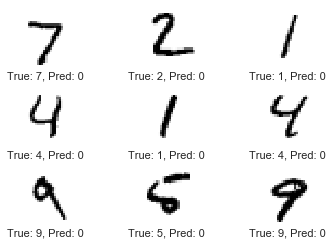

In [51]:
plot_example_errors()

In [52]:
optimize(num_iterations=1)

In [53]:
print_accuracy()

Accuracy on test-set: 40.7%


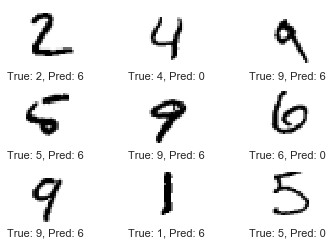

In [54]:
plot_example_errors()

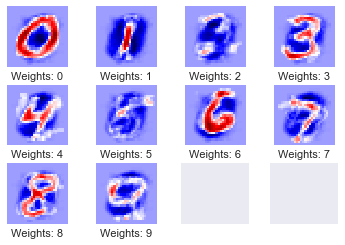

In [55]:
plot_weights()

In [56]:
optimize(num_iterations=9)

In [57]:
print_accuracy()

Accuracy on test-set: 78.2%


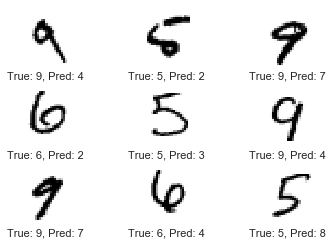

In [58]:
plot_example_errors()


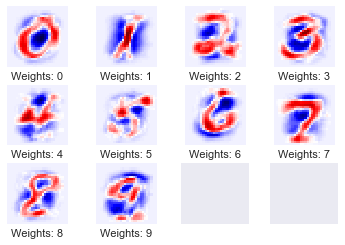

In [59]:
plot_weights()

In [60]:
# We have already performed 10 iterations.
optimize(num_iterations=990)

In [61]:
print_accuracy()

Accuracy on test-set: 91.6%


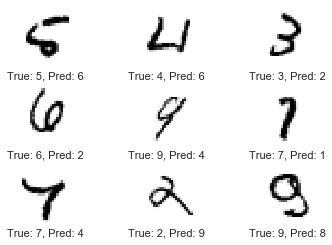

In [62]:
plot_example_errors()

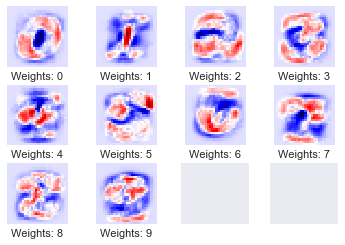

In [63]:
plot_weights()

[[ 967    0    2    2    1    1    4    1    2    0]
 [   0 1105    4    2    1    1    3    2   17    0]
 [   9    6  938    8   14    1    9    8   36    3]
 [   3    0   28  916    2   23    2    6   25    5]
 [   1    2    7    1  932    0    6    2    7   24]
 [  15    4   12   40   14  741   15    5   39    7]
 [  18    3   13    1   15    8  895    1    4    0]
 [   3   12   38    9   11    1    0  916    3   35]
 [  12    5    9   21    9   19   10    6  881    2]
 [  12    5    6   11   68    6    0   15   13  873]]


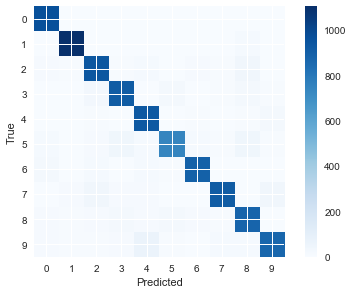

In [64]:
print_confusion_matrix()

In [65]:
# We have already performed 1000 iterations.
optimize(num_iterations=9000)

In [66]:
print_accuracy()

Accuracy on test-set: 92.4%


In [67]:
session.close()